## 자연어 처리 과제입니다

파일명 제출 : nlp_{이름}.ipynb  
제출기한일 : 2023.10.10  
제출 이메일 : bluelemonsky7@gmail.com  
분석 대상 데이터 : 네이버 평점 test 데이터

평가 관점
1. 코드를 작성하여 error 없이 진행해야 함
2. 각종 모델을 비교하거나 선택한 이유 등을 작성
3. train : test 비율은 7:3으로 함
4. 최종 평가에서 train 데이터에 대한 정확도 90 이상, test 데이터에 대한 정확도는 85 이상을 목표로 함
5. 모델 평가에서 고정된 결과가 나오도록 하세요 (random seed 설정)

Part 1 . 분석 환경에 대한 정보를 보여주세요

1. python 버전 = 3.10.13
2. 주요 사용 패키지 버전 정보 

In [1]:
# 졍규 표현식 패키지
import re

# 토크나이저 패키지
from nltk.tokenize import word_tokenize
from konlpy.tag import Kkma, Okt
from tokenizers import Tokenizer
from nltk.tokenize import RegexpTokenizer

# 벡터화 패키지
# from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# 분류 모델 패키지
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# XAI 관련
from lime.lime_text import LimeTextExplainer

# 분류 모델 평가
from sklearn.metrics import classification_report

# 데이터 핸들링
import numpy as np
import pandas as pd

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

# 기타
from tqdm import tqdm 

In [2]:
import nltk as nltk
import konlpy as konlpy
import sklearn as sklearn
import xgboost as xgb
import matplotlib as mlt

print('nltk :', nltk.__version__)
print('konlpy :', konlpy.__version__)
print('sklearn :', sklearn.__version__)
print('xgboost :', xgb.__version__)
print('numpy :', np.__version__)
print('pandas :', pd.__version__)
print('seaborn :', sns.__version__)
print('matplotlib :', mlt.__version__)

nltk : 3.8.1
konlpy : 0.6.0
sklearn : 1.3.1
xgboost : 2.0.0
numpy : 1.26.0
pandas : 2.1.1
seaborn : 0.13.0
matplotlib : 3.8.0


Part 2. 분석 데이터를 로드하세요

1. 판다스로 데이터를 read 하세요

In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', sep='\t', encoding='utf-8')
test = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', sep='\t', encoding='utf-8')

display(train.head())
print('😊')
display(test.head())

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


😊


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


Part 3. 텍스트 데이터를 EDA하세요

1. 통계적으로 텍스트를 확인해 보세요
2. 시각화 해보세요
3. 불용어(stop words)를 찾아보세요
4. 기타 여러 방법으로 EDA를 해보세요

In [4]:
train[train.label == 0]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
...,...,...,...
149990,6373651,이걸 영화라고 찎었냐?,0
149992,9335962,공포나 재난영화가 아니라 아예 대놓고 비급 크리쳐개그물임ㅋㅋ 음악 완전 흥겹다ㅋ 5...,0
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB
None


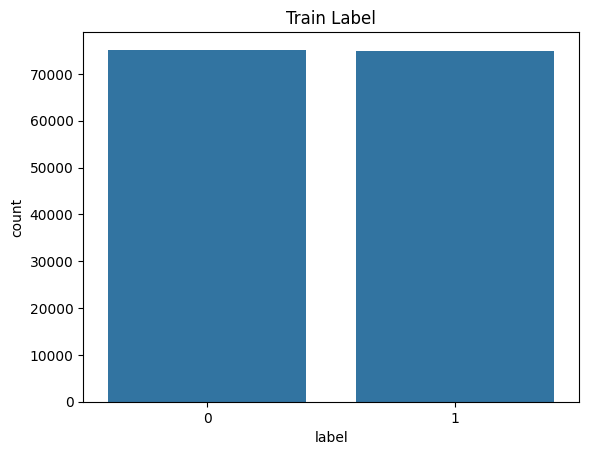


😊
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB
None


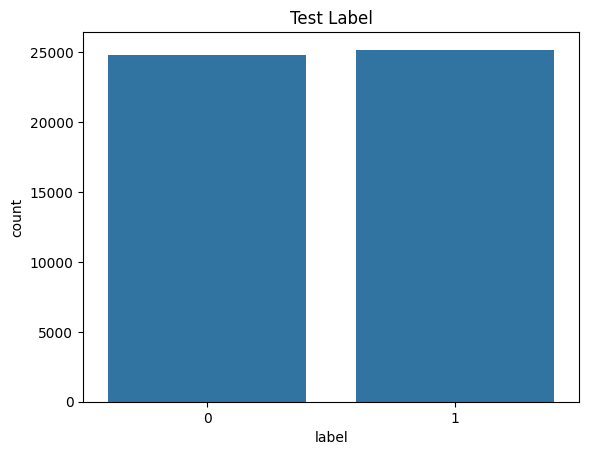

In [5]:
# 데이터 null값 확인 및 label 분포 확인 

print(train.info())
sns.countplot(train, x='label')
plt.title('Train Label')
plt.show()
print()
print('😊')
print(test.info())
sns.countplot(test, x='label')
plt.title('Test Label')
plt.show()

In [6]:
# 한글과 공백을 제외하고 모두 제거 + NaN drop
# train과 test data 모두 같은 방법으로 전처리 

# train data
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
train['document'].replace('', np.nan, inplace=True)
print('<< train >>')
print(train.isnull().sum())
train.dropna(inplace=True)
print('⬇️')
print(train.isnull().sum())
print()
print(f'train data shape :', train.shape)

print('=' * 20)

# test data
test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
test['document'].replace('', np.nan, inplace=True)
print('<< test >>')
print(test.isnull().sum())
test.dropna(inplace=True)
print('⬇️')
print(test.isnull().sum())
print()
print(f'test data shape :', test.shape)

<< train >>
id            0
document    814
label         0
dtype: int64
⬇️
id          0
document    0
label       0
dtype: int64

train data shape : (149186, 3)
<< test >>
id            0
document    274
label         0
dtype: int64
⬇️
id          0
document    0
label       0
dtype: int64

test data shape : (49726, 3)


In [7]:
# data split 
X_train, y_train = train['document'], train['label']
X_test, y_test = test['document'], test['label']

print(X_train.head(), y_train.head())
print(X_train.shape, y_train.shape)
print('😊')
print(X_test.head(), y_test.head())
print(X_test.shape, y_test.shape)

0                                    아 더빙 진짜 짜증나네요 목소리
1                           흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                            교도소 이야기구먼 솔직히 재미는 없다평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
Name: document, dtype: object 0    0
1    1
2    0
3    0
4    1
Name: label, dtype: int64
(149186,) (149186,)
😊
0                                          굳 ㅋ
2             뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아
3                    지루하지는 않은데 완전 막장임 돈주고 보기에는
4    만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠
5                            음악이 주가 된 최고의 음악영화
Name: document, dtype: object 0    1
2    0
3    0
4    0
5    1
Name: label, dtype: int64
(49726,) (49726,)


Part 4. 텍스트 데이터를 임베딩 하세요

1. 텍스트 토크나이즈를 해보세요
2. 텍스트를 벡터화 하세요
    - one-hot, count, tf-idf

In [8]:
# 1. tokenize

class UserTokenizers :
    def __init__(self) -> None:
        self.okt = Okt()
        self.kkma = Kkma()
        self.bpe_tokenizer_pretrained = Tokenizer.from_file('./tokenizer_data/bpe_tokenizer.json')

    @staticmethod
    def whitespaceToken(data : str) -> list :
        token_rs = data.split(' ')
        return token_rs
    
    @staticmethod
    def regexsplitToken(data : str , pat : str = '[\,\.!?\n]') -> list :
        re_rs = re.split(pat, data , maxsplit= 0)
        token_rs = [rs_unit.strip() for rs_unit in re_rs if len(rs_unit.strip()) > 1]
        return token_rs
    
    @staticmethod
    def regexselectToken(data : str , pat : str = '[\w]+') -> list :
        token_rs = RegexpTokenizer(pat).tokenize(data)
        return token_rs
    
    def BPETokenizer(self, data : str ) -> list :
        token_rs = self.bpe_tokenizer_pretrained.encode(data).tokens
        return token_rs
    
    #한글과 영어를 같이 사용
    def tokenizingKorEng(self, data :str ) -> list :
        kor_re = re.findall('[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+', data)
        kor_str = ' '.join(kor_re)

        eng_re = re.findall('[a-zA-Z]+', data)
        eng_str = ' '.join(eng_re)

        kor_rs = self.okt.morphs(kor_str)
        eng_rs = word_tokenize(eng_str)

        token_rs = kor_rs + eng_rs

        return token_rs
    
    def konlpyNounsTokenizer(self, data:str) -> list :
        token_rs = self.kkma.nouns(data)
        return token_rs

In [9]:
ut_cls = UserTokenizers()

print(X_train[0])
# ut_cls.tokenizingKorEng(X_train[0])
print(ut_cls.konlpyNounsTokenizer(X_train[0]))
print(ut_cls.BPETokenizer(X_train[0]))

아 더빙 진짜 짜증나네요 목소리
['더빙', '목소리']
['아</w>', '더빙</w>', '진짜</w>', '짜증나', '네요</w>', '목소리</w>']


In [10]:
# 불용어 적용
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로',
             '자', '에', '와', '한', '하다']

In [11]:
# 2. vectorize

## one-hot
## count vectorize

## tf-idf
tfidf_vect = TfidfVectorizer(tokenizer=ut_cls.BPETokenizer , stop_words=stopwords)
tfidf_vect.fit(X_train)


c:\Users\hsl\anaconda3\envs\lhs_3.10\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\hsl\anaconda3\envs\lhs_3.10\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가</w>', '걍</w>', '과</w>', '는</w>', '도</w>', '들</w>', '를</w>', '에</w>', '와</w>', '으로</w>', '은</w>', '의</w>', '이</w>', '자</w>', '잘</w>', '좀</w>', '하다</w>', '한</w>'] not in stop_words.
  warnings.warn(


TfidfVectorizer(stop_words=['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과',
                            '도', '를', '으로', '자', '에', '와', '한', '하다'],
                tokenizer=<bound method UserTokenizers.BPETokenizer of <__main__.UserTokenizers object at 0x0000021A54786C50>>)

In [12]:
tfidf_vect.get_feature_names_out()

array(['<unk>', 'ㄱ', 'ㄱ</w>', ..., '힘들었다</w>', '힘을</w>', '힘이</w>'],
      dtype=object)

In [13]:
class TransformVect :
    def __init__(self, vec_model) -> None:
        self.vec_model = vec_model
    
    def transVect_run(self, chunk_size : int = 500 , data : pd.DataFrame = None ) -> np.array :
        data_len = len(data) 
        for st_idx in tqdm(range(0, data_len, chunk_size)):
            tmp_data = data[st_idx:st_idx+chunk_size]
            if st_idx == 0:
                vec_arr = self.vec_model.transform(tmp_data).toarray()
            else :
                tmp_data_arr = self.vec_model.transform(tmp_data).toarray()
                vec_arr = np.concatenate([vec_arr, tmp_data_arr], 0)                
        return vec_arr

In [14]:
tfv_cls = TransformVect(tfidf_vect)
y_train.sum() , y_train.count() , y_test.sum() , y_test.count()

(74463, 149186, 25048, 49726)

Part 5. 분류 모델을 훈련하고 적용해 보세요

In [15]:
X_train = tfv_cls.transVect_run(chunk_size=10000, data=X_train)
X_test = tfv_cls.transVect_run(chunk_size=10000, data=X_test)

100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


In [16]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(149186, 9491) (149186,)
(49726, 9491) (49726,)


In [17]:
# random seed

random_seed_num = 77

In [18]:
# Decision Tree
clf_decision = DecisionTreeClassifier(random_state=random_seed_num, max_depth=5)
clf_decision.fit(X_train, y_train)

rfc_decision = RandomForestClassifier(random_state=random_seed_num, max_depth=5)
rfc_decision.fit(X_train, y_train)

clf_kneighbors = KNeighborsClassifier(n_neighbors=3 , weights='distance', leaf_size=50)
clf_kneighbors.fit(X_train, y_train)

clf_logistic = LogisticRegression(max_iter=3000, random_state=random_seed_num)
clf_logistic.fit(X_train, y_train)

clf_xgb = XGBClassifier(random_state = random_seed_num, max_depth=5)
clf_xgb.fit(X_train, y_train)

clf_ensemble = VotingClassifier(estimators=[('logistic', clf_logistic), ('kneighbors', clf_kneighbors), ('xgboost', clf_xgb)], voting = 'soft')
clf_ensemble.fit(X_train, y_train)

c:\Users\hsl\anaconda3\envs\lhs_3.10\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


VotingClassifier(estimators=[('logistic',
                              LogisticRegression(max_iter=3000,
                                                 random_state=77)),
                             ('kneighbors',
                              KNeighborsClassifier(leaf_size=50, n_neighbors=3,
                                                   weights='distance')),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=77, ...))],
                 voting='soft')

Part 6. 모델을 평가하세요

In [19]:
# Classification Report
model_names = ['DecisionTree', 'RandomForest', 'KNN', 'Logistic', 'XGBoost', 'Voting_Soft', 'Voting_Hard']
clf = [clf_decision, rfc_decision, clf_kneighbors, clf_logistic, clf_xgb, clf_ensemble]

for clf, model_name in zip(clf, model_names):

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    print('🔔', model_name, '🔔')
    print(classification_report(y_train, y_train_pred))
    print(classification_report(y_test, y_test_pred))
    print()

🔔 DecisionTree 🔔
              precision    recall  f1-score   support

           0       0.94      0.06      0.11     74723
           1       0.51      1.00      0.68     74463

    accuracy                           0.53    149186
   macro avg       0.73      0.53      0.39    149186
weighted avg       0.73      0.53      0.39    149186

              precision    recall  f1-score   support

           0       0.94      0.06      0.11     24678
           1       0.52      1.00      0.68     25048

    accuracy                           0.53     49726
   macro avg       0.73      0.53      0.39     49726
weighted avg       0.73      0.53      0.40     49726


🔔 RandomForest 🔔
              precision    recall  f1-score   support

           0       0.65      0.88      0.75     74723
           1       0.81      0.52      0.64     74463

    accuracy                           0.70    149186
   macro avg       0.73      0.70      0.69    149186
weighted avg       0.73      0.70      